In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [5]:
# 1. library
import torch

find_links = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"

!pip install -q \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    torch-geometric \
    -f $find_links

# seed set
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Installation Complete.")

Installation Complete.


In [6]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}') # 1113 proteins graph
print(f'Number of nodes: {dataset[0].x.shape[0]}') # ave. 31 nodes
print(f'Number of features: {dataset.num_features}') # helix, sheet, Turn
print(f'Number of classes: {dataset.num_classes}') # 0: non-enzyme, 1: enzyme

Processing...


Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of nodes: 31
Number of features: 3
Number of classes: 2


Done!


### The PROTEINS dataset is a standard benchmark for graph classification in bioinformatics. 
- 1,113 protein structures data as graphs
- classify to enzyme or non-enzyme
  - Nodes represent secondary structure elements 
  - edges represent spatial or sequential neighbors
- Enzymes
  - Catalyze chemical reactions by binding specific substrates (Lock and Key mechanism).
  - Must possess deep 3D crevices known as 'Active Sites' or 'Binding Pockets' where the reaction occurs.
  - Often exhibit complex, rounded shapes (e.g., TIM barrels) formed by the folding of alpha-helices and beta-sheets.
- Non-enzymes
  - Primarily serve roles in structural support (e.g., collagen), signaling, or transport.
  - Tend to have relatively flat (globular) or elongated (fibrous) shapes.
  - Typically lack the deep, specific reaction pockets found in enzymes.

In [7]:
# Proteins Dataset)

from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 8842], x=[2326, 3], y=[64], batch=[2326], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8882], x=[2401, 3], y=[64], batch=[2401], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 6838], x=[1820, 3], y=[64], batch=[1820], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 7344], x=[1982, 3], y=[64], batch=[1982], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 9348], x=[2455, 3], y=[64], batch=[2455], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 7620], x=[2076, 3], y=[64], batch=[2076], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 12274], x=[3157, 3], y=[64], batch=[3157], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 8206], x=[2216, 3], y=[64], batch=[2216], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 10436], x=[2768, 3], y=[64], batch=[2768], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 9060], x=[2486, 3], y=[64], batch=[2486], ptr=[65])
 - Batch 

In [8]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

# 2. 모델 정의 (GCN & GIN)
# ==========================================

# (1) GCN Model (평균 중심)

class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout, # Readout (Pooling): 분자 단위로 정보 합치기 (평균)
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)
# (2) GIN Model (구조 중심)
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),# GIN은 내부적으로 MLP를 사용합니다.
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout# GIN은 보통 합산(Add) 풀링을 사용합니다.
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [9]:
# 3. 개별 모델 학습 (Training)

def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.68 | Train Acc: 57.63% | Val Loss: 0.66 | Val Acc: 61.82%
Epoch  20 | Train Loss: 0.61 | Train Acc: 69.37% | Val Loss: 0.56 | Val Acc: 75.02%
Epoch  40 | Train Loss: 0.60 | Train Acc: 70.23% | Val Loss: 0.58 | Val Acc: 72.32%
Epoch  60 | Train Loss: 0.59 | Train Acc: 70.88% | Val Loss: 0.55 | Val Acc: 74.45%
Epoch  80 | Train Loss: 0.59 | Train Acc: 70.43% | Val Loss: 0.57 | Val Acc: 71.26%
Epoch 100 | Train Loss: 0.59 | Train Acc: 71.09% | Val Loss: 0.55 | Val Acc: 71.04%
Test Loss: 0.61 | Test Acc: 73.96%

Epoch   0 | Train Loss: 1.53 | Train Acc: 59.21% | Val Loss: 0.69 | Val Acc: 55.50%
Epoch  20 | Train Loss: 0.54 | Train Acc: 73.85% | Val Loss: 0.42 | Val Acc: 83.18%
Epoch  40 | Train Loss: 0.51 | Train Acc: 74.84% | Val Loss: 0.45 | Val Acc: 80.98%
Epoch  60 | Train Loss: 0.50 | Train Acc: 75.98% | Val Loss: 0.44 | Val Acc: 78.08%
Epoch  80 | Train Loss: 0.48 | Train Acc: 76.76% | Val Loss: 0.44 | Val Acc: 81.27%
Epoch 100 | Train Loss: 0.47 | Train Acc

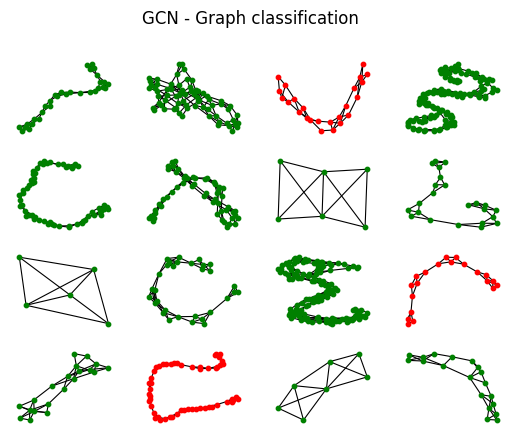

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


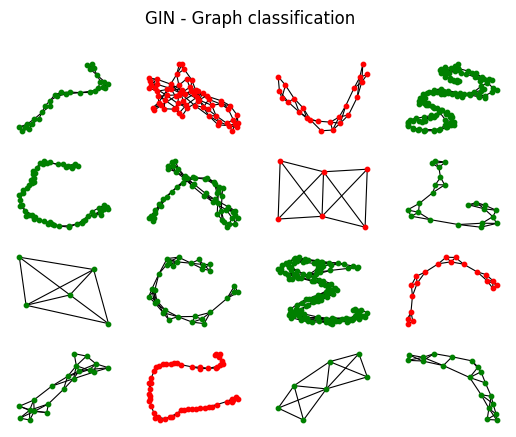

In [11]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


In [12]:
# 4. 앙상블 평가 (Ensemble Evaluation)소프트 보팅 (Soft Voting)

gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     74.48%
GIN accuracy:     76.04%
GCN+GIN accuracy: 75.00%
